#### MAG Dataset
We considered the MAG-10 dataset (preprocessed in (https://github.com/TheoryInPractice/overlapping-ecc/tree/master/data/MAG-10)), a subset of the Microsoft Academic Graph in which the nodes are the authors (labelled with a code), the hyperedges correspond to a publication by those authors, and the hyperedges are categorised according to one of the 10 computer science conferences, the most common conference in which they published. 

In particular, we considered the _International Conference on Machine Learning_ (ICML), filtering by code 3.
In this notebook, we want to show the different assignments of a color (i.e. a fibre) to authors labelled as 7979 and 4508 in case we represent the dataset as a hypergraph or as a multigraph.

See the complete paper for more details _Bertè, Margherita, and Tommaso Gili. ["Fibration Symmetries and Cluster Synchronization in Multi-Body Systems."](https://arxiv.org/abs/2510.11207)(2025)._

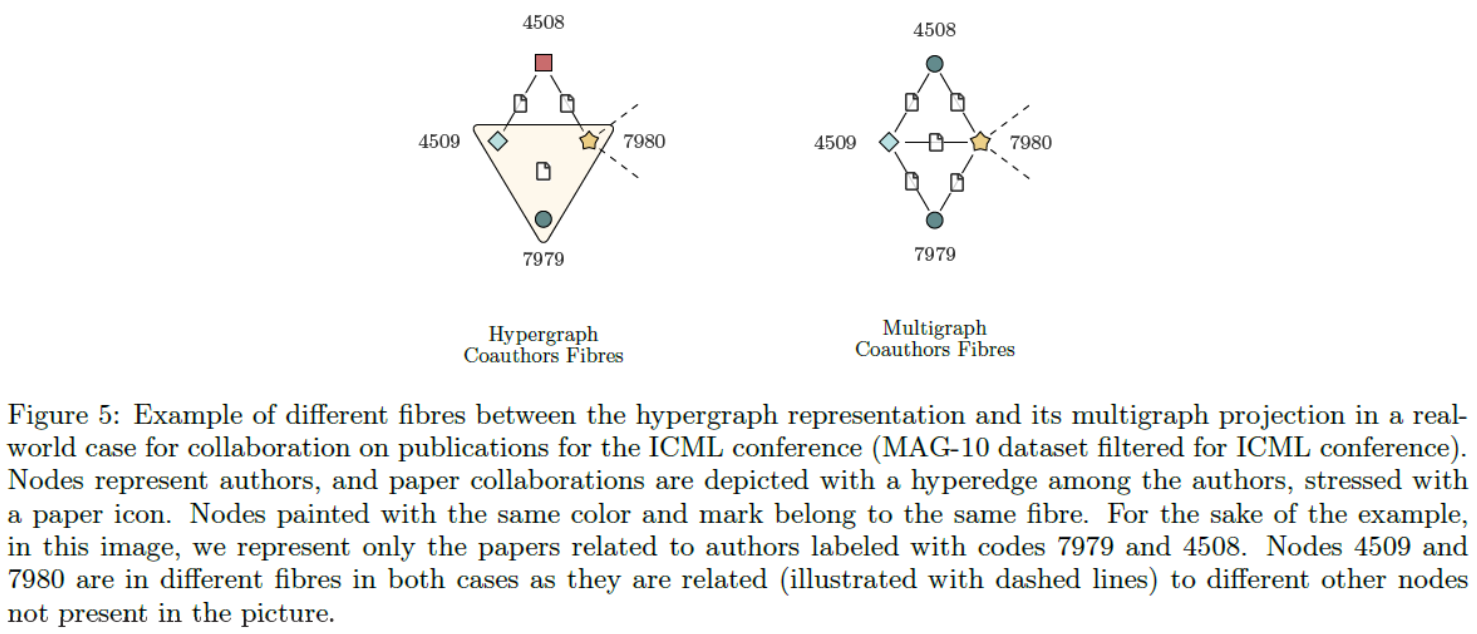

In [ ]:
import sys
sys.path.insert(0, '../Utilities')

from utilities_fibration import *

from itertools import combinations

import hypergraphx as hx
from hypergraphx.core.hypergraph import Hypergraph
from hypergraphx.representations.projections import bipartite_projection

import pandas as pd
import networkx as nx

In [4]:
# Step 2: Load the data
filename = '../Data/MAG/colored-MAG.txt'

data = []
with open(filename, 'r') as file:
    for line in file:
        parts = line.strip().split()
        if len(parts) != 2:
            continue
        nodes_str, conf_code = parts
        nodes = list(map(int, nodes_str.split(',')))
        data.append({'hyperedge': nodes, 'conference_code': int(conf_code)})

df = pd.DataFrame(data)

In [5]:
i = 3 # Code of Conference to analyze

################ Hypergraph ################

print('***********************************************')
print(f'Conference code: {i}')

min_conf_code = i
filtered = df[df['conference_code'] == min_conf_code]

# Extract hyperedges as list of lists
hyperedges_list = filtered['hyperedge'].tolist()

# 1. Get all unique nodes from filtered hyperedges
unique_nodes = sorted(set(node for hyperedge in hyperedges_list for node in hyperedge))

# 2. Create the dictionary mapping node -> integer (starting from 0)
node_to_int = {node: idx for idx, node in enumerate(unique_nodes)}

transformed_hyperedges = [
[node_to_int[node] for node in hyperedge]
for hyperedge in hyperedges_list
]

edge_list_sc_filtered = Hypergraph(transformed_hyperedges)
bsc_tot = bipartite_projection(edge_list_sc_filtered)

bsc = bsc_tot[0]
bhg_dict = bsc_tot[1]
color_dict = bipartite.color(bsc)

result_hg = kameicock_coloring(bsc, color_dict)

node_cluster_hg = {k: v for k, v in result_hg.items() if k.startswith('N')}
cl_hg = []
# Consider the node partition for the hypergraph
for val in set(node_cluster_hg.values()):
    cl_hg.append([k for k, v in node_cluster_hg.items() if v == val])

edge_name_dict = bhg_dict
edge_col_dict = result_hg

dic = {v: edge_col_dict[k] for k, v in edge_name_dict.items()}

list_c = cl_hg

# Transform the list of the node cluster substituting with the original names
clusters = [[edge_name_dict[item] for item in sublist] for sublist in list_c]    

# CLusters with more than one nodes
c = [e for e in clusters if len(e) > 1]
num_nontrivial_clusters = len(c)
print(f'Number of non trivial clusters for the hypergraph representation: {num_nontrivial_clusters}')


***********************************************
Conference code: 3
Number of non trivial clusters for the hypergraph representation: 1354


In [6]:
################ Multigraph ################
print('***********************************************')
print(f'Conference code: {i}')

# Transform hyperedges in pair
edge_list_sc_filtered_hpg = transformed_hyperedges
edge_list_sc_filtered_g = [
    list(c)
    for f in edge_list_sc_filtered_hpg
    for c in combinations(f, 2)
]

g_test = nx.MultiGraph(edge_list_sc_filtered_g)
result_graph_g_test = kameicock_coloring_multi(g_test, {})#, initial_types)

# colors only of node in layer 0
nodes_coloring_gr_test = {n: c for n, c in result_graph_g_test.items()}
# Set of clusters
cl_gr_test = []

for val in set(nodes_coloring_gr_test.values()):
    cl_gr_test.append([k for k, v in nodes_coloring_gr_test.items() if v == val])

c_g = [e for e in cl_gr_test if len(e) > 1]
num_nontrivial_clusters_g = len(c_g)
print(f'Number of non trivial clusters for the multigraph representation: {num_nontrivial_clusters_g}')


***********************************************
Conference code: 3
Number of non trivial clusters for the multigraph representation: 1355


In [7]:
# Check the differences in the fibres

set1_hg = set(frozenset(inner) for inner in c)
set2_g = set(frozenset(inner) for inner in c_g)

print(f'Number of non trivial clusters hypergraph: {num_nontrivial_clusters}')
print(f'Number of non trivial clusters multigraph: {num_nontrivial_clusters_g}')

print(c)
print(c_g)

print(f'Are the two set of clusters the same? {set2_g == set1_hg}')

node_diff = set1_hg.symmetric_difference(set2_g)
node_diff = [list(e) for e in node_diff]
print(f'Number of different clusters: {len(node_diff)}, Clusters: {node_diff}')

# Dictionary to retrieve original node names
int_to_node ={idx: node for node, idx in node_to_int.items()}

# Nodes to check as their clusters are different
node_to_checks = [int_to_node[i] for i in node_diff[0]]
print(f'Node codes: {node_to_checks}')

# Check the hyperedges containing those nodes and the different fibres they belong to
for node_to_check in node_diff[0]:
    print(f'/nChecking node: {int_to_node[node_to_check]}')
    edges_lists_hypg = find_hyperedges_containing_all_nodes(transformed_hyperedges, [node_to_check])
    edges_lists_multig = find_hyperedges_containing_all_nodes(edge_list_sc_filtered_g, [node_to_check])

    # Retrieve the original node names
    # obtain a list of lists with orginal names
    edges_lists_hypg_original_names = [[int_to_node[n] for n in i] for i in edges_lists_hypg]
    edges_lists_multig_original_names = [[int_to_node[n] for n in i] for i in edges_lists_multig]
    print(f'Hypergraph hyperedges: {edges_lists_hypg_original_names}')
    print(f'Multigraph edges: {edges_lists_multig_original_names}')



Number of non trivial clusters hypergraph: 1354
Number of non trivial clusters multigraph: 1355
[[1408, 1409, 1099, 5802], [3955, 3956, 3957, 3959], [9329, 9220], [276, 1266], [1247, 2254, 1746], [1653, 1657], [4245, 6751], [1301, 1302], [626, 627], [508, 958, 8908], [984, 4108, 4109], [146, 1964], [169, 5282, 9012, 9013, 9014, 9015], [7455, 7700], [7256, 7257, 7258], [5793, 3033], [8202, 8204, 8205, 8207], [4567, 4568], [91, 6327, 6328, 4571, 9236, 9237, 9604, 9606, 9607, 1877, 1878, 1880, 3774, 3886, 6304, 4901, 4902, 4904, 4393, 4394, 4395, 1117, 1118, 1119, 4119, 8898, 8899, 8075, 8076, 8077, 4296, 7294, 7295, 7789, 7790, 7791, 7518, 7519, 8148, 8171, 8172, 8173, 3096, 3097, 3098], [4068, 4138, 4139], [6889, 6890], [6691, 6692], [1082, 1083, 1084], [6568, 6570, 6571, 6572], [9151, 9152], [5066, 5644], [2199, 8304, 1736, 5089, 520, 5410, 2923, 8891, 8943, 1681, 5923, 9308, 746, 4357, 3850, 7668, 9722, 7781, 505, 8250, 2095, 8384, 3379, 3962, 4256, 3428], [3006, 5953], [6731, 6732], 